In [ ]:
!pip install gym==0.21.0
!pip install gym[toy_text]==0.21.0
!pip install gym[classic_control]==0.21.0
!pip install tqdm
!pip install torch torchvision torchaudio
!pip install numpy==1.24.1
!pip install pyglet==1.5.27

  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package m

# House Energy Management Challenge

Imagine you have a nice house by the sea on a green sustainable island, you have a PV rooftop installed, and a battery bank. The energy market on this island functions as follows:

1. Energy prices change hourly, your monthly energy bill is calculated by summing the energy you consumed every hour multiplied by the cost of energy at that hour.
2. An extra CO2 emmissions fee is added to your bill which is proportional to your net energy consumption. However your CO2 emmissions also vary hourly, since different power plants with different technologies produce your hourly demand.

Your goal is to develop a smart battery management system (BMS) using reinforcement learning to know when it is best to charge or discharge your battery to minimize your over all electricity bill.


## Actor and Critic

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from torch.autograd import Variable

# Initalize weigths for the neurnal network
WEIGHTS_FINAL_INIT = 3e-3
BIAS_FINAL_INIT = 3e-4


def fan_in_uniform_init(tensor, fan_in=None):
    """
    Utility function for initializing weigths for actor and critic
    """
    if fan_in is None:
        fan_in = tensor.size(-1)

    w = 1. / np.sqrt(fan_in)
    nn.init.uniform_(tensor, -w, w)


class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, action_dim=1):
        super(Critic, self).__init__()

        self.action_dim = action_dim

        # Standard Settings
        self.linear1 = nn.Linear(input_size + self.action_dim, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], output_size)

        # Weight Init
        fan_in_uniform_init(self.linear1.weight)
        fan_in_uniform_init(self.linear1.bias)

        fan_in_uniform_init(self.linear2.weight)
        fan_in_uniform_init(self.linear2.bias)

        # Final weigths distribution is predfeined
        nn.init.uniform_(self.linear3.weight, -WEIGHTS_FINAL_INIT, WEIGHTS_FINAL_INIT)
        nn.init.uniform_(self.linear3.bias, -BIAS_FINAL_INIT, BIAS_FINAL_INIT)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = state

        # Layer 1
        x = torch.cat((x, action), 1)
        x = F.relu(self.linear1(x))
        # Layer 2
        # actions are added as input for the seconed layer of the critic
        x = F.relu(self.linear2(x))
        # Layer 3
        x = self.linear3(x)

        return x


class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=3e-4):
        super(Actor, self).__init__()

        # define layers of the network
        self.linear1 = nn.Linear(input_size, hidden_size[0])
        self.linear2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.linear3 = nn.Linear(hidden_size[1], output_size)

        # Weight Init
        fan_in_uniform_init(self.linear1.weight)
        fan_in_uniform_init(self.linear1.bias)

        fan_in_uniform_init(self.linear2.weight)
        fan_in_uniform_init(self.linear2.bias)

        # Final weigths distribution is predfeined
        nn.init.uniform_(self.linear3.weight, -WEIGHTS_FINAL_INIT, WEIGHTS_FINAL_INIT)
        nn.init.uniform_(self.linear3.bias, -BIAS_FINAL_INIT, BIAS_FINAL_INIT)

    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = state

        # Layer 1
        x = F.relu(self.linear1(x))
        # Layer 2
        x = F.sigmoid(self.linear2(x))
        # Layer 3
        x = torch.tanh(self.linear3(x))

        return x

## Memory and Noise

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque


class GaussianNoise(object):
    def __init__(self, action_space, mu=0.0, sigma=0.1, regulation_coef=1, decay_rate=0):

        self.action_dim = action_space.shape[0]
        self.low = action_space[0,0]
        self.high = action_space[0,1]
        self.distance = abs(self.low - self.high)

        self.decay_rate = decay_rate
        self.regulation_coef = regulation_coef
        self.mu = mu
        self.sigma = sigma

        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def get_action(self, action, step=0):

        noise_list = (np.random.normal(self.mu, self.sigma, self.action_dim)
                      * ((1 - self.decay_rate) ** step) * self.regulation_coef)

        if any(x < 0.01 for x in ((noise_list) ** 2) ** 0.5):
            noise_list = np.random.normal(0, 0.01, self.action_dim)

        noisy_action = np.clip(action + noise_list, self.low, self.high)

        return noisy_action

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

## Update Process

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DDPG:
    def __init__(self, env, hidden_size=(256, 128), actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99,
                 tau=1e-3, max_memory_size=50000):

        # BiddingMarket_energy_Environment Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]

        # DDPG specific Params
        self.gamma = gamma
        self.tau = tau
        self.hidden_size = hidden_size
        self.output_size = 1  # only for critic

        # Networks
        self.actor = Actor(self.num_states, self.hidden_size, self.num_actions).to(device)
        self.actor_target = Actor(self.num_states, self.hidden_size, self.num_actions).to(device)
        self.critic = Critic(self.num_states, self.hidden_size, self.output_size, self.num_actions).to(device)
        self.critic_target = Critic(self.num_states, self.hidden_size, self.output_size, self.num_actions).to(device)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Training
        self.memory = Memory(max_memory_size)
        self.critic_criterion = nn.MSELoss()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)

    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0).to(device))
        self.actor.eval()
        action = self.actor.forward(state)
        self.actor.train()
        # action = action.detach().numpy()[0,:]
        action = action.detach().cpu().numpy()[0, :]
        return action

    def update(self, batch_size):

        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)

        states = torch.FloatTensor(np.asarray(states), device=device)
        actions = torch.FloatTensor(np.asarray(actions), device=device)
        rewards = torch.FloatTensor(np.asarray(rewards), device=device)
        next_states = torch.FloatTensor(np.asarray(next_states), device=device)
        # done = torch.FloatTensor(np.asarray(done), device=device)

        # Critic loss
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q

        # update networks
        self.critic_optimizer.zero_grad()
        # Critic loss
        critic_loss = self.critic_criterion(Qvals, Qprime)
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        policy_loss.backward()
        self.actor_optimizer.step()

        # update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

## Train

In [ ]:
%run Challenge_Env.ipynb
import time
import matplotlib.pyplot as plt
import matplotlib
import pyglet

# Intialize environment
t_lim = 24*7
env = EnergyEnvironment(t_lim = t_lim, data_link="train_data.pkl")

# check your state variables
print('State variables: ',env.state_variables)
print()

# check observation space
print('Observation space (min,max): ',env.observation_space)
print()

# check action space
print('Action space(min,max): ',env.action_space)
print()

State variables:  ['Month', 'Hour', 'Day Type', 'Consumption_kWh', 'Solar_Generation_W', 'Price', 'Price_6h', 'Price_12h', 'Price_24h', 'kg_CO2/kWh', 'Temperature', 'Humidity', 'Diffuse_Radiation', 'Direct_Radiation', 'Battery_Charge']

Observation space (min,max):  [[1.00000000e+00 1.20000000e+01]
 [1.00000000e+00 2.40000000e+01]
 [1.00000000e+00 7.00000000e+00]
 [5.70000000e-02 7.98748332e+00]
 [0.00000000e+00 9.76250000e+02]
 [2.10000000e-01 5.40000000e-01]
 [2.10000000e-01 5.40000000e-01]
 [2.10000000e-01 5.40000000e-01]
 [2.10000000e-01 5.40000000e-01]
 [7.03828731e-02 2.81796217e-01]
 [5.60000000e+00 3.22000000e+01]
 [1.00000000e+01 1.00000000e+02]
 [0.00000000e+00 1.01700000e+03]
 [0.00000000e+00 9.53000000e+02]
 [1.00000000e-01 1.00000000e+00]]

Action space(min,max):  [[-1.  1.]]



In [ ]:
# Do some feature engineering if you want
state_vars_to_drop = [...] # type the features you would like to drop and not consider here (strings that belong to the above list)
env.drop_state_variables(state_vars_to_drop)

Invalid state variable Ellipsis


In [ ]:

#####################  hyper parameters  ####################
RENDER = True
render_mode = 'plot' # can be "plot"
MAX_EPISODES = 50

# DDPG
BATCH_SIZE = 64
ACTOR_LR =1e-4
CRITIC_LR = 1e-3
GAMMA = 0.7
TAU = 1e-3
MAX_MEMORY_SIZE = 50000

# Noise
REGULATION_COEFFICENT = 1 # only moves the variance (if =1: sigma stays the same)
DECAY_RATE = 0
NOISE_VARIANCE = 0.1

# Initalize your agent (You can use DQN agent with action space discretization)
ddpg = DDPG(env, hidden_size=[256, 128], actor_learning_rate=ACTOR_LR, critic_learning_rate=CRITIC_LR, gamma=GAMMA,
            tau=TAU, max_memory_size=MAX_MEMORY_SIZE)


# Random Guassian Noise gets added to the actions for exploratation
noise = GaussianNoise(env.action_space, mu=0, sigma=NOISE_VARIANCE,
                      regulation_coef=REGULATION_COEFFICENT, decay_rate=DECAY_RATE)

# Training process
episodic_rewards = []

for i in range(MAX_EPISODES):
    # reset everything
    noise.reset()
    state = env.reset().astype('float64').T
    ep_reward = 0
    done = 0

    while not done:
        # Add exploration noise
        action = ddpg.get_action(state)
        action = noise.get_action(action)

        # Take a step in environment and get next state, reward, and done
        next_state, reward, done = env.step(action[0], psi=10, smoothing=True)

        #Save memory
        ddpg.memory.push(state, action, reward, next_state.astype('float64').T, done)


        if len(ddpg.memory) > BATCH_SIZE:
            ddpg.update(BATCH_SIZE)

        state = next_state.astype('float64').T
        ep_reward += reward

        if RENDER:
            env.render(i, render_mode=render_mode)

    episodic_rewards.append(ep_reward)



plt.ioff()
plt.show()

KeyboardInterrupt: ignored

## Test

In [ ]:
%run Challenge_Env.ipynb
import time
import matplotlib.pyplot as plt
import matplotlib
import pyglet

# Intialize environment
env = EnergyEnvironment(t_lim=t_lim, data_link="test_data.pkl")

# check your state variables
print('State variables: ',env.state_variables)
print()

# check observation space
print('Observation space (min,max): ',env.observation_space)
print()

# check action space
print('Action space(min,max): ',env.action_space)
print()

State variables:  ['Month', 'Hour', 'Day Type', 'Consumption_kWh', 'Solar_Generation_W', 'Price', 'Price_6h', 'Price_12h', 'Price_24h', 'kg_CO2/kWh', 'Temperature', 'Humidity', 'Diffuse_Radiation', 'Direct_Radiation', 'Battery_Charge']

Observation space (min,max):  [[1.00000000e+00 1.20000000e+01]
 [1.00000000e+00 2.40000000e+01]
 [1.00000000e+00 7.00000000e+00]
 [9.75000000e-08 6.84313333e+00]
 [0.00000000e+00 7.86083333e+02]
 [2.10000000e-01 5.40000000e-01]
 [2.10000000e-01 5.40000000e-01]
 [2.10000000e-01 5.40000000e-01]
 [2.10000000e-01 5.40000000e-01]
 [7.03828731e-02 2.81796217e-01]
 [5.60000000e+00 3.22000000e+01]
 [1.00000000e+01 1.00000000e+02]
 [0.00000000e+00 1.01700000e+03]
 [0.00000000e+00 9.53000000e+02]
 [1.00000000e-01 1.00000000e+00]]

Action space(min,max):  [[-1.  1.]]



In [ ]:
# Do the same feature engineering you did with training dataset
state_vars_to_drop = [...] # type the features you would like to drop and not consider here (strings that belong to the above list)
env.drop_state_variables(state_vars_to_drop)

KeyboardInterrupt: ignored

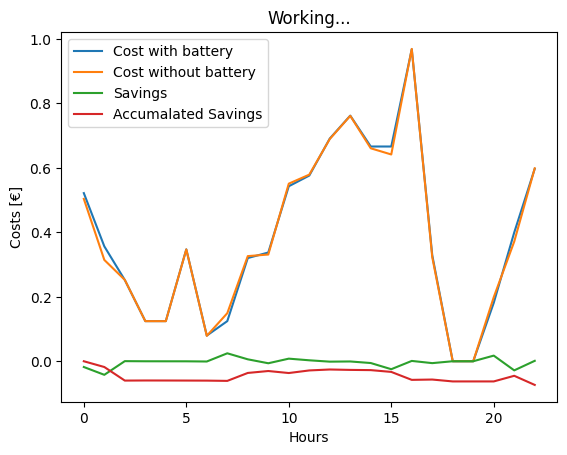

<Figure size 640x480 with 0 Axes>

In [ ]:
RENDER = True
plt.ion()

while not done:
  # Add exploration noise
  action = ddpg.get_action(state)

  # Take a step in environment and get next state, reward, and done
  next_state, reward, done = env.step(action[0])

  state = next_state.astype('float64').T
  ep_reward += reward

  if RENDER:
      env.render(0)

In [ ]:
print('Total savings: ', sum(env.savings))